# BERT Fine-Tuning Tutorial with PyTorch

코드&설명 제공 (Thanks to)
- 이영준 (2020 KEPCO 문제해결형 인공지능기술개발교육 TA)

본 실습에서는 `huggingface` PyTorch 라이브러리를 이용하여 sentiment classification에서 BERT를 어떻게 fine-tuning 하는지에 대한 부분을 설명합니다. 또한, BERT 모델을 fine-tuning 하기 위해 amazon review 데이터(영어)를 사용합니다. 

## Documentation

본 실습 자료를 위해 참고한 자료는 아래와 같습니다.

- Chris McCormick's tutorial: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
- huggingface github: https://github.com/huggingface/transformers
- huggingface documentation: https://huggingface.co/transformers/
- 딥러닝을 이용한 자연어처리 입문: https://wikidocs.net/115055

## Step 0: Connect to Google drive



In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Step 1: Import modules

In [ ]:
import pickle as pc
import os
import numpy as np
# csv 모듈은 CSV 형식(쉼표로 구분된 표 형식) 데이터를 읽고 쓰는 클래스를 제공
import csv
import torch

# torch 버전 확인
print("Pytorch Version: ", torch.__version__)

# GPU 사용 가능한지 여부 확인
if torch.cuda.is_available():
    
    # PyTorch 에게 GPU 사용할거라고 알려주기
    device = torch.device("cuda")
    
    print("There are %d GPU(s) available." % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

Pytorch Version:  1.12.1+cu113
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Step 2: Installing the Hugging Face Library
* Hugging Face는 언어모델 공유 플랫폼&커뮤니티 (https://github.com/huggingface) 

* 논문으로 발표된 다양한 Transformer 기반의 모델이 구현되어 있음

* 사용자들은 자신이 구축한 언어모델을 Huggingface의 모델 Hub를 통해서 손쉽게 공유할 수 있음


In [ ]:
# transformers 팩키지 설치
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 15.5 MB/s 
     |████████████████████████████████| 6.6 MB 58.8 MB/s 
     |████████████████████████████████| 163 kB 56.0 MB/s 


## Step 3: Configure the experiments

- 모델의 실험(학습 및 평가)을 위해 필요한 파라미터 및 인자 설정
    - Hyperparameter: hidden unit size, vocabulary size, max length, dropout rate 등
    - Argument: file directory 등

*Note: 해당 실습 자료에서는 데이터 경로만 지정*

In [ ]:
train_filename = '/content/gdrive/My Drive/Colab Notebooks/aivle/data/amazon/bert_train_data_all.csv'
test_data = '/content/gdrive/My Drive/Colab Notebooks/aivle/data/amazon/bert_balanced_data'
test_label = '/content/gdrive/My Drive/Colab Notebooks/aivle/data/amazon/bert_balanced_label'

## Step 4: Load Amazon Review Dataset

- `load_data`: amazon review data 에서 **[reviewText, label]** 형태로 데이터를 불러오는 함수

In [ ]:
def load_data(filename):
    data = list()
    label = list()
    
    f = open(filename, 'r', encoding='utf-8')
    reader = csv.reader(f)
    for idx, line in enumerate(reader):
        if idx == 0:
            continue
        # line[2]에 label 1(긍정), 0(부정) line[5]에 review text가 있음 
        data.append(line[5])
        label.append(int(line[2]))

    f.close() 
   
    # data와 label 사이즈 일치 여부 확인
    assert len(data) == len(label)  
    return data, label

In [ ]:
# train_data : 리뷰문장 (text), train_lable : 1(긍정) 또는 0(부정)
train_data, train_label = load_data(train_filename)

In [ ]:
print("Size of train data: {}".format(len(train_data)))
print("Size of train label: {}".format(len(train_label)))

Size of train data: 10727
Size of train label: 10727


## Step 5: Tokenization & Input Formatting

본 단계에서는 BERT 가 학습한 format 에 맞게 amazon review dataset 을 변환해줍니다. 

### Step 5-1: BERT Tokenizer

BERT 모델에 text 를 입력으로 주기 위해서는 BERT 에서 사용한 tokenizer 를 이용하여 text 를 token 단위로 나누고, 각 token 들을 특정 index 로 mapping 시켜줍니다. 

- `BertTokenizer`: punctuation splitting + wordpiece
  - `bert-base-uncased`: 12-layer, 768-hidden size, 12-heads, 110M parameters. Trained on **lower-cased** English text.
  - uncased는 대문자를 모두 소문자로 바꾼 후 토크나이즈하는 것을 의미 (vs. cased)

In [ ]:
from transformers import BertTokenizer

# BERT tokenizer 불러오기
# do_lower_case : True이면 모두 소문자로 변환, False이면 대소문자 구분
print("Loading BERT tokenizer...")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# 하나의 sentence에 대해 BertTokenizer 적용

# Print the original sentence.
print("Original: ", train_data[0])
print("Original: ", train_data[1])
print()

# Print the sentence split into tokens.
print("Tokenized: ", tokenizer.tokenize(train_data[0]))
print("Tokenized: ", tokenizer.tokenize(train_data[1]))
print()

# Print the sentence mapped to token ids.
print("Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_data[0])))
print("Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_data[1])))
print()

Original:  I never thought that I would find the right moisturizer for my skin. I have combination skin with large pores that get gunked up if I neglect them and I ve struggled for some time to find a product that would provide sufficient moisture without breaking me out or turning my face into an oil-slick. This is truly a holy grail moisturizer for me and has a nice face feel and natural herbal scent. Will definitely repurchase!  I m a 30 something multi-ethnic muxer and a recent convert to korean beauty. This is my new routine and my skin has never felt or looked bettter!  1) Banila Co Clean It Zero Reservatrol 2) Neogen Green Tea Real Fresh Foam Cleanser 3) MISSHA Time Revolution First Treatment Essence (Morning) or MISSHA Time Revolution Night Repair New Science Ampoule (Night) 4) Cosrx Oil-Free Ultra-Moisturizing Lotion (Morning and ever OTHER night) or Cosrx Ultimate Nourishing Rice Overnight Mask
Original:  I started using Kbeauty products after becoming frustrated last year wi

### Step 5-2: Required Formatting

- 각 문장의 처음과 끝에 special token 더하기
- 각 문장을 maximum length 만큼 자르고 padding token 채워주기
- 각 문장에서 padding token 과 실제 token 들 구분하기 위한 attention masking 적용

#### Special Tokens

- `[SEP]`: 모든 문장 뒤에 `[SEP]` 더하기
- `[CLS]`: 문장의 앞에 `[CLS]` 더하기

<center><img src="https://github.com/passing2961/KEMC/blob/master/bert_clf.png?raw=true" width="50%" height="40%" title="Bert4Clf" alt="Bert4Clf"></img></center>


#### Sentence Length & Attention Mask

실제 데이터에 있는 문장들의 길이는 다양합니다. 이를 위해서 BERT 는 아래의 과정을 통해 해결합니다. 

- 모든 문장들은 하나의 고정된 길이인 max_len 를 지녀야하고, 이를 위해서 max_len 보다 긴 문장의 경우에는 잘라줍니다. 실제 문장의 길이가 max_len 보다 작은 경우에는 남은 부분을 padding token `[PAD]` 으로 채워줍니다.
  - `[PAD]`: BERT 사전에서 index 0 에 해당
- max_len 는 512 tokens 입니다.


<center><img src="https://github.com/passing2961/KEMC/blob/master/bert_pad.png?raw=true" width="60%" height="50%" title="Bert4Pad" alt="Bert4Pad"></img></center>

- **Attention mask**: 0과 1을 이용해 토큰이 `[PAD]` 인지 실제 값인지를 구분해주기 위한 binary tensor 값입니다. 
BERT가 어텐션 연산을 할 때, 불필요하게 패딩 토큰에 대해서 어텐션을 하지 않도록 실제 단어와 패딩 토큰을 구분할 수 있도록 알려주는 값입니다. 이 값은 0과 1 두 가지 값을 가지는데, 숫자 1은 해당 토큰은 실제 단어이므로 마스킹을 하지 않는다라는 의미이고, 숫자 0은 패딩 토큰이므로 마스킹을 한다는 의미입니다.





#### Sentences to IDs

`tokenizer.encode` 함수를 이용하여 모든 문장들에 대해 위의 과정들을 한꺼번에 처리합니다.

In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []

# For every sentence
for sent in train_data:
    # 'encode' will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the '[CLS]' token to the start.
    #   (3) Append the '[SEP]' token to the end.
    #   (4) Map tokens to their IDs.
    #   max_length : 문장의 최대길이
    #   encoded_sent : token IDs
    #---------------------------------------------------------------
    #      연습 (1)     tokenizer의 encode 함수를 호출해 주세요.  
    #---------------------------------------------------------------                
  
    encoded_sent = tokenizer.encode(sent, 
                                    add_special_tokens=True, # [CLS], [PAD], [SEP] 사용여부
                                    max_length = 64)
    
    # Add the encoded sentence to the list
    input_ids.append(encoded_sent)

# Print train data[0]
print("Original: ", train_data[0])
print()
print("Token IDs: ", input_ids[0])

# Print special tokens and tokenized sentence
print("\n[CLS] token: {:}, ID: {:}".format(tokenizer.cls_token, tokenizer.cls_token_id))
print("\n[PAD] token: {:}, ID: {:}".format(tokenizer.pad_token, tokenizer.pad_token_id))
print("\n[SEP] token: {:}, ID: {:}".format(tokenizer.sep_token, tokenizer.sep_token_id))
print("\nTokenized: ", tokenizer.convert_ids_to_tokens(input_ids[0]))

Original:  I never thought that I would find the right moisturizer for my skin. I have combination skin with large pores that get gunked up if I neglect them and I ve struggled for some time to find a product that would provide sufficient moisture without breaking me out or turning my face into an oil-slick. This is truly a holy grail moisturizer for me and has a nice face feel and natural herbal scent. Will definitely repurchase!  I m a 30 something multi-ethnic muxer and a recent convert to korean beauty. This is my new routine and my skin has never felt or looked bettter!  1) Banila Co Clean It Zero Reservatrol 2) Neogen Green Tea Real Fresh Foam Cleanser 3) MISSHA Time Revolution First Treatment Essence (Morning) or MISSHA Time Revolution Night Repair New Science Ampoule (Night) 4) Cosrx Oil-Free Ultra-Moisturizing Lotion (Morning and ever OTHER night) or Cosrx Ultimate Nourishing Rice Overnight Mask

Token IDs:  [101, 1045, 2196, 2245, 2008, 1045, 2052, 2424, 1996, 2157, 11052, 94

#### Padding & Truncating

`tf.keras.preprocessing.sequence.pad_sequences` 를 이용하여 **MAXLEN** 만큼 padding 과정을 진행합니다.


In [ ]:
print("Max length: ", max([len(each) for each in input_ids]))

Max length:  64


In [ ]:
import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))

MAXLEN = 64
# post-sequence truncation, post-sequence padding
# padding value 0, type of output sequences long
input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, 
                                                          maxlen=MAXLEN, dtype="long", value=0, truncating="post", padding="post")

print("\nPadding is done.")

Tensorflow version: 2.8.2

Padding is done.


#### Attention Masks



In [ ]:
# Create attention masks
attention_masks = [] # 각 문장에 대한 attention mask 리스트를 저장

# 토큰 시퀀스에서 패딩에 해당하는 부분은 0, 패딩이 아닌 부분은 1을 넣은 mask를 생성
# 패딩 부분은 모델 내에서 Attention을 수행하지 않아 학습속도를 향상
# For every sentence
for sent in input_ids:
    # Create the attention mask.
    #  - If a token ID is 0, then it's padding, set the mask to 0.
    #  - If a token ID is not 0 ( > 0), then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)
print("\nAttention masking is done.")


Attention masking is done.


#### Training & Validation Split

`sklearn` 라이브러리에 `train_test_split` 함수를 이용하여 amazon review dataset 의 90% 는 training 으로 10% 는 validation 으로 나눠줍니다.

- `random_state`: reproducibility 를 위함

*Note: 아래 코드 블럭을 두 번 이상 실행시키면서 나오는 출력값을 확인해보세요.*



In [ ]:
# Use train_test_split to split our data into train and validation sets for training
from sklearn.model_selection import train_test_split

# train_test_split(arrays, test_size, train_size, random_state, shuffle, stratify)
#     arrays : 분할시킬 데이터
#     test_size : 테스트 데이터셋의 비율 (default = 0.25)
#     random_state : 데이터 셔플 시 seed value. 호출할 때마다 동일한 학습 데이터, 테스트 데이터 셋을 생성하기 위해 설정
#     shuffle : 셔플 여부 (default = True)
#     stratify : 지정한 Data의 비율을 유지한다. 예를 들어, Label Set인 Y가 25%의 0과 75%의 1로 이루어진 Binary Set일 때
#     stratify=Y로 설정하면 나누어진 데이터셋들도 0과 1을 각각 25%, 75%로 유지
# 반환값 : (학습 데이터, 테스트 데이터, 학습데이터 label, 테스트데이터 label)
# test_size=0.1로 설정, Use 90% for training and 10% for validation
train_inputs, valid_inputs, train_labels, valid_labels = train_test_split(input_ids, train_label, random_state=2018, test_size=0.1)

# Do the same for the masks.
train_masks, valid_masks, _, _ = train_test_split(attention_masks, train_label, random_state=2018, test_size=0.1)

# print train_inputs, valid_inputs
# 첫번째 학습데이터, 첫번째 attention mask를 출력해서 확인
print(train_inputs[:1])
print(train_masks[:1])

[[  101  4149  2023  2043  2559  2005  2227  3688  3647  1999 10032  1012
   1045  2293  2009  1998  2097  3613  2000  2224  2035  1996  2051  2085
   1012   102     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


#### Converting to PyTorch Data Types

In [ ]:
# Convert all inputs and labels into torch tensors, the required data type for our model.
# torch.tensor(data) -> tensor를 생성
train_inputs = torch.tensor(train_inputs)
valid_inputs = torch.tensor(valid_inputs)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

train_masks = torch.tensor(train_masks)
valid_masks = torch.tensor(valid_masks)

PyTorch 의 `DataLoader` class 를 이용하여 amazon review dataset 에 대한 `iterator` 를 생성합니다.

- `TensorDataset`: tensor 를 입력받아 dataset 형태로 변환해주는 함수
- `RandomSampler`: 입력 dataset 에 element 들의 index 를 무작위로 샘플링하는 함수
- `SequentialSampler`: 입력 dataset 에 element 들의 index 를 순차적으로 샘플링하는 함수
- `DataLoader`: dataset 과 sampler 를 이용하여 주어진 dataset 에 대하여 배치사이즈만큼 데이터를 반환해주는 함수


In [ ]:
# torch.utils.data : 파이토치의 데이터 로딩 유틸리티. 데이터셋, 데이터로더, 샘플러 등을 제공함
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

#---------------------------------------------------------------
#      연습 (2) train_data, valid_data의 데이터 로더를 생성해 주세요.
#---------------------------------------------------------------   
# Create the DataLoader for our training set.
# torch.utils.data.TensorDataset(*tensors)
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

## Step 6: Train our classification model

Pre-train 된 BERT 모델을 불러와서 그 위에 single linear layer 하나를 올립니다. 그리고 전체 모델을 fine-tuning 을 진행합니다.

### Step 6-1: BertForSequenceClassification

`huggingface` 라이브러리에서 제공하는 `BertForSequenceClassification` 모델을 사용하면 우리가 원하는 모델을 얻을 수 있습니다. 즉, pre-train BERT 모델 위에 single linear layer 하나가 더해져있는 모델을 불러옵니다. 따라서, 해당 모델을 우리가 원하는 task 에 맞게 end-to-end 방식으로 fine-tuning 을 진행할 수 있습니다.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassfication, the pretrained BERT model 
# with a single linear classification layer on top.
# BERT 모델의 네트워크 형태를 출력
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab
                                                      num_labels = 2, # The number of output labels 2 for binary classification
                                                                      # You can increase this for multi-class tasks
                                                      output_attentions = False, # whether the model returns attentions weight (correponding to multi-head self attentions)
                                                      output_hidden_states = False) # whether the model returns all hidden states

# Tell PyTorch to run this model on the GPU
# (model의 모든 parameter를 GPU에 loading)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.\n".format(len(params)))
print("=== Embedding Layer ===\n")

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== First Transformer ====\n")

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== Output Layer====\n")

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

=== Embedding Layer ===

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (76

### Step 6-2: Optimizer & Learning Rate Scheduler

- `optimizer`: 모델의 loss function 을 최소화되게 하는 모델의 파라미터들을 찾는 알고리즘
- `learning rate scheduler`: learning rate 를 조절해주는 방법
  - `learning rate warmup`: 초기에 learning rate 를 0 으로 설정하고 이를 일정 기간동안 heurisitc 하게 키워주는 방식 (*초기값이 너무 크면 학습이 불안정*)

- `learning rate warmup` 관련 논문: https://arxiv.org/abs/1812.01187

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for "Weight Decay fix"
# Weight Decay: weight들의 값이 증가하는 것을 제한함으로써 모델의 복잡도를 감소시켜 오버피팅을 방지하는 기법 
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (we recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
print("number of batches:", len(train_dataloader))
total_steps = len(train_dataloader) * epochs

print("total_steps:", total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

number of batches: 302
total_steps: 1208


### Step 6-3: Training Loop


#### **본 실습에서 학습 과정**

- `DataLoader` 를 통해 data 와 label 배치사이즈 단위로 가져오기
- Forward pass: data 와 label 을 `BertForSequenceClassification` 모델에 입력으로 주기
- Backward pass:
  - minibatch gradient 계산 (backpropagation)
  - 모델의 파라미터들 업데이트 (optimization)
  



In [ ]:
# Function to calculate the accuracy of our predictions vs labels
# numpy argmax : 해당 차원(axis)의 값 중에서 가장 큰 값의 인덱스를 반환
# flatten() : 다차원 배열을 1차원으로 변환
# sum() : 배열 내 전체 값들의 합
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Take a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round(elapsed))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# Set the seed value all over the place to make this reproducible
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42
set_seed(seed_val)

# Store the average loss after each epoch so we can plot them
loss_values = []

# For each epoch
for epoch in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')
    
    # Measure how long the training epoch takes.
    t0 = time.time()
    
    # Reset the total loss for this epoch.
    total_loss = 0.
    
    # Put the model into training mode.
    # Don't be mislead -- the call to 'train' just changes the "mode", it doesn't "perform" the training.
    # 'dropout' and 'bachnorm' layers behave differently during training vs test
    model.train()
    
    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress
            print("Batch {:>5,} of {:>5,}. Elapsed: {:}.".format(step, len(train_dataloader), elapsed))
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        #---------------------------------------------------------------
        #      연습 (3) 아래 라인에 그래디언트를 0으로 초기화하는 함수를 호출해 주세요.
        #--------------------------------------------------------------- 
        model.zero_grad()
        
        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.        
        #---------------------------------------------------------------
        #      연습 (4) 아래 라인에 파라미터를 업데이트하는 함수를 호출해 주세요.
        #--------------------------------------------------------------- 
        optimizer.step()
        
        # Update the learning rate.
        scheduler.step()
    
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    
    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.
    
    print("")
    print("Running Validation...")
    
    t0 = time.time()
    
    # Put the model in evaluation mode -- the dropout layers behave differently during evaluation
    model.eval()
    
    # Tracking variables
    eval_loss, eval_acc = 0., 0.
    
    # Evaluate data for one epoch
    for valid_step, batch in enumerate(valid_dataloader):
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            #---------------------------------------------------------------
            #      연습 (5) 아래 함수에서 파라미터를 채워주세요
            #--------------------------------------------------------------- 
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
        # Get the "logits" output by the model.
        # The "logits" are the output values prior to applying an activation function like the softmax
        # output 타입: class transformers.modeling_outputs.SequenceClassifierOutput
        # (https://huggingface.co/docs/transformers/v4.22.2/en/main_classes/output#transformers.modeling_outputs.SequenceClassifierOutput)
        # our model will return (outputs.loss(optional)=None, outputs.logits)
        
        logits = outputs[0]
        
        # Move logits and labels to CPU (Module을 통해 나온 tensor을 후처리에 사용하거나, 계산된 loss를 로깅 등)
        # detach() : 파이토치는 tensor에서 이루어진 모든 연산을 추적해서 graph에 기록해두는데 이 연산 기록으로부터 
        # 그래디언트가 계산되고 역전파가 이루어지게 된다. detach()는 이 연산 기록으로부터 분리한 tensor을 반환하는 method     
        # cpu() : GPU 메모리에 올려져 있는 tensor를 cpu 메모리로 복사하는 method   
        # numpy() : tensor를 numpy로 변환하여 반환
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_acc = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_acc += tmp_eval_acc        
    
    # Report the final accuracy for this validation run.
    print("Accuracy: {0:.2f}".format(eval_acc / (valid_step + 1)))
    print("Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")        


======== Epoch 1 / 4 ========
Training...
Batch    40 of   302. Elapsed: 0:00:15.
Batch    80 of   302. Elapsed: 0:00:28.
Batch   120 of   302. Elapsed: 0:00:42.
Batch   160 of   302. Elapsed: 0:00:55.
Batch   200 of   302. Elapsed: 0:01:09.
Batch   240 of   302. Elapsed: 0:01:22.
Batch   280 of   302. Elapsed: 0:01:35.

Average training loss: 0.19
Training epoch took: 0:01:43

Running Validation...
Accuracy: 0.96
Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
Batch    40 of   302. Elapsed: 0:00:13.
Batch    80 of   302. Elapsed: 0:00:27.
Batch   120 of   302. Elapsed: 0:00:40.
Batch   160 of   302. Elapsed: 0:00:53.
Batch   200 of   302. Elapsed: 0:01:07.
Batch   240 of   302. Elapsed: 0:01:20.
Batch   280 of   302. Elapsed: 0:01:33.

Average training loss: 0.07
Training epoch took: 0:01:41

Running Validation...
Accuracy: 0.97
Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...
Batch    40 of   302. Elapsed: 0:00:13.
Batch    80 of   302. Elapsed

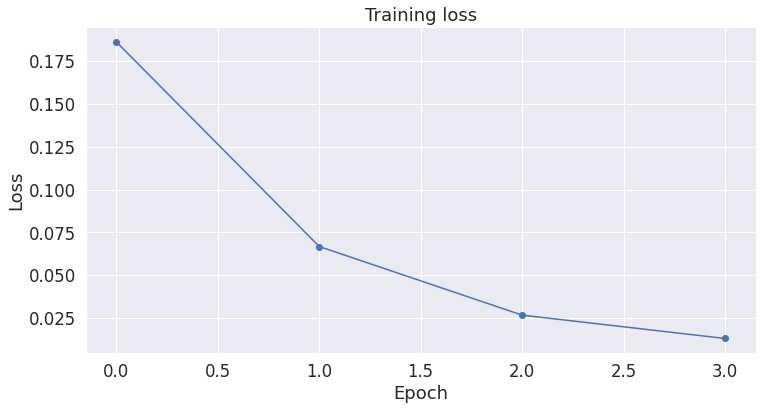

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Step 7: Performance on Test set

- `sklearn` 라이브러리의 `classification_report` 함수 이용하여 **accuracy, precision, recall, f1 score** 평가 지표를 이용하여 test dataset 에 대해 성능 확인
  - dataset 의 label 이 균형적인 경우 (balanced data): **accuracy**
  - dataset 의 label 이 불균형적인 경우 (imbalanced data): **f1 score**

### Step 7-1: Load Amazon Review Test Dataset


In [ ]:
# pickle 모듈로 테스트 파일을 load : bert_balanced_data, bert_balanced_label
with open(test_data, 'rb') as f:
    test_data = pc.load(f)
with open(test_label, 'rb') as f:
    test_label = pc.load(f)


print("Size of test data: {}".format(len(test_data)))
print("Size of test label: {}".format(len(test_label)))


Size of test data: 174
Size of test label: 174


### Step 7-2: Tokenization & Input Formatting

본 단계에서는 fine-tuning layer 까지 학습한 BERT 모델의 입력 format 에 맞게 amazon review test dataset 을 변환해줍니다. (*위에서 진행한 방법과 동일*)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in test_data:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=MAXLEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks array
attention_masks = []

# For every sentence
for sent in input_ids:
    # Create the attention mask.
    #  - If a token ID is 0, then it's padding, set the mask to 0.
    #  - If a token ID is not 0 ( > 0), then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# Convert to tensors
# input_ids : 테스트 문장에 포함된 단어 ids
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_label)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
# For validation the order doesn't matter, so we'll just read them sequentially.
prediction_sampler = SequentialSampler(prediction_data) 
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Step 7-3: Evaluate on Test Set

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader (batch에서 데이터 추출)
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  # logist, labels 텐서를 CPU로 이동하여 정확도 계산
  # detach() : 텐서에서 이루어진 연산 기록으로부터 분리한 텐서를 반환
  # cpu() : GPU 메모리에 올려져 있는 tensor를 cpu 메모리로 복사
  # numpy() : tensor를 numpy로 변환하여 반환
 
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  # predictions : 예측값 array
  # true_labels : 정답값 array
  # logits array의 값들 중 가장 큰 값의 index를 반환
  # when axis = 1, argmax identifies the maximum value for every row. 
  predictions.extend(np.argmax(logits, axis=1).flatten()) # [0, 1, 1, 0, ...]
  true_labels.extend(label_ids.flatten()) # [0, 1, 0, 0, ...]


print('DONE.')

Predicting labels for 174 test sentences...
DONE.


In [ ]:
# accuracy, precision, recall, f1 score 성능 확인
from sklearn.metrics import classification_report
    
target_names = ['negative', 'positive']

# sklearn.metrics.classification_report(y_true, y_pred, digits, target_names)
# support is the number of actual occurrences of the class in the specified dataset.
print(classification_report(true_labels, predictions, digits=4, target_names=target_names))

              precision    recall  f1-score   support

    negative     0.9531    0.7011    0.8079        87
    positive     0.7636    0.9655    0.8528        87

    accuracy                         0.8333       174
   macro avg     0.8584    0.8333    0.8304       174
weighted avg     0.8584    0.8333    0.8304       174

